In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import hvplot.pandas
import plotly.express as px
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import  risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import plotting

import warnings
warnings.filterwarnings("ignore")


In [2]:
#formatting floats to 3 decimals to avoid use of scientific notation
pd.options.display.float_format = '{:.3f}'.format

In [3]:
#Defining symbols in our portfolio.
tickers = ["TSLA", "BIDU", "NVDA", "AAL", "AMD", "WMT", "DIS", "DHR", "PANW","AAPL","MCL.CN","FI"] 

In [4]:
portfolio_creation_date = "2023-11-10"
portfolio_rebalance_date = "2023-11-10"

In [5]:
#Downloading 10 years of data from yahoo finance.
stock_data = yf.download(tickers, period="10y")

[*********************100%%**********************]  12 of 12 completed


In [6]:
#putting stock data into a df called prices
prices = pd.DataFrame(stock_data["Adj Close"].dropna(how="all"))
prices

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
Date,,,,,,,,,,,,
2013-11-11,21.938,16.252,3.340,151.600,47.236,62.127,26.345,0.020,3.681,13.957,9.647,63.726
2013-11-12,22.173,16.282,3.440,150.430,46.944,61.609,26.407,0.020,3.688,13.760,9.187,63.484
2013-11-13,21.975,16.301,3.540,152.980,46.855,62.700,26.798,0.020,3.789,13.817,9.247,63.637
2013-11-14,22.305,16.537,3.520,158.990,47.287,63.655,26.800,0.020,3.805,14.067,9.173,63.782
2013-11-15,22.522,16.438,3.500,162.330,47.318,63.637,27.153,0.020,3.794,15.237,9.030,63.895
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,11.660,178.994,111.750,108.400,195.520,84.020,119.640,0.075,457.510,237.000,219.270,164.880
2023-11-07,11.750,181.581,113.450,108.010,198.250,84.590,119.210,0.075,459.550,242.080,222.180,165.650
2023-11-08,12.010,182.649,113.590,107.420,196.820,84.500,120.130,0.075,465.740,241.080,222.110,164.300


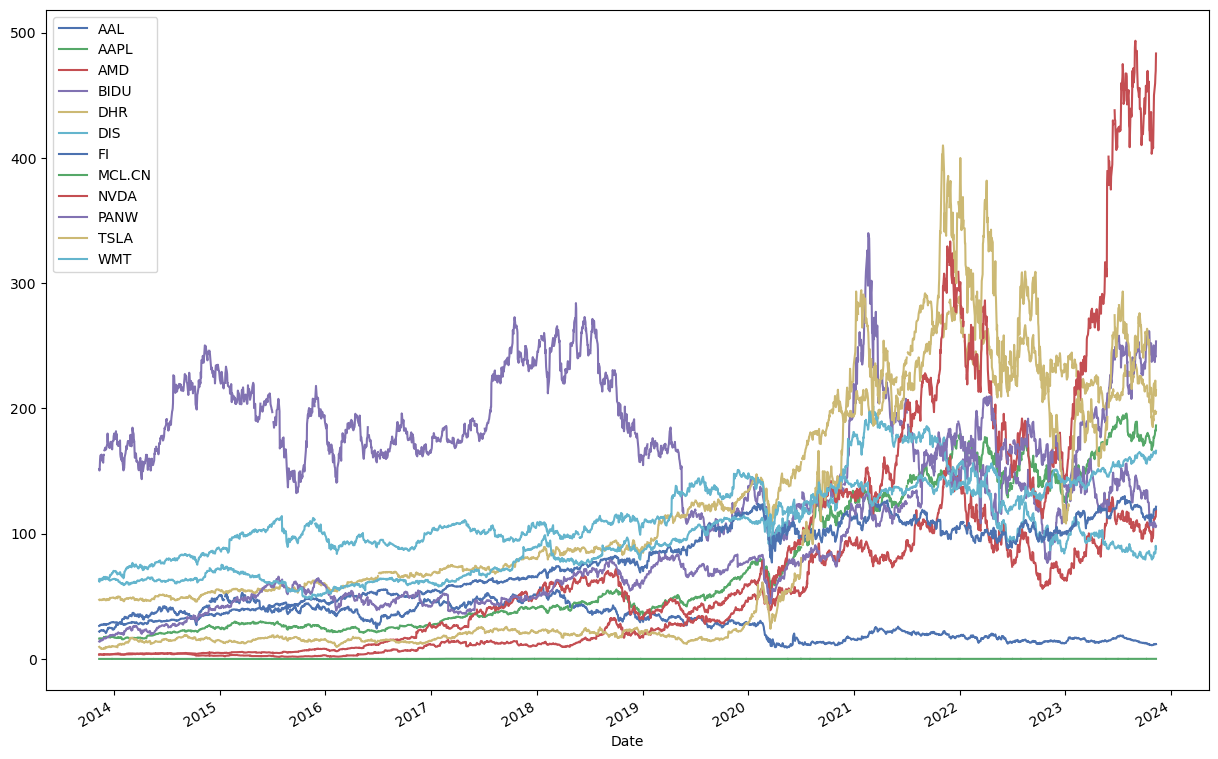

In [7]:
#Quick chart of prices over time for basket of stocks
prices[prices.index >= "2013-01-01"].plot(figsize=(15,10));

In [8]:
#created a covariance matrix through pyportfolioOpt to compare all stocks to eachother
sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
AAL,0.250,0.042,0.060,0.057,0.026,0.060,0.043,-0.010,0.067,0.047,0.071,0.010
AAPL,0.042,0.079,0.067,0.045,0.031,0.033,0.034,0.002,0.071,0.042,0.065,0.019
AMD,0.060,0.067,0.330,0.074,0.046,0.044,0.043,0.010,0.152,0.067,0.107,0.020
BIDU,0.057,0.045,0.074,0.195,0.030,0.037,0.034,0.006,0.075,0.049,0.082,0.011
DHR,0.026,0.031,0.046,0.030,0.052,0.023,0.028,0.005,0.046,0.032,0.038,0.015
DIS,0.060,0.033,0.044,0.037,0.023,0.073,0.035,0.006,0.046,0.036,0.044,0.014
FI,0.043,0.034,0.043,0.034,0.028,0.035,0.061,-0.005,0.048,0.032,0.043,0.016
MCL.CN,-0.010,0.002,0.010,0.006,0.005,0.006,-0.005,3.539,0.000,-0.015,0.010,0.000
NVDA,0.067,0.071,0.152,0.075,0.046,0.046,0.048,0.000,0.211,0.072,0.106,0.022
PANW,0.047,0.042,0.067,0.049,0.032,0.036,0.032,-0.015,0.072,0.148,0.076,0.013


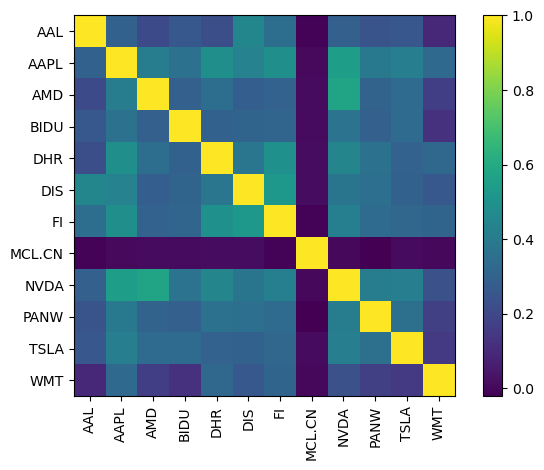

In [9]:
#plotted the correlations.  MCL.CN is the interesting product here with low correlation to essentially all other products here.
plotting.plot_covariance(sample_cov, plot_correlation=True);

In [10]:
#Used pyportfolioOpt to find our expected returns per stock using Capital Asset Pricing Model.
mu = expected_returns.capm_return(prices)
mu

AAL      0.339
AAPL     0.254
AMD      0.470
BIDU     0.327
DHR      0.183
DIS      0.219
FI       0.202
MCL.CN   1.585
NVDA     0.424
PANW     0.284
TSLA     0.447
WMT      0.108
Name: mkt, dtype: float64

In [11]:
# Use hvplot.bar to create bar plot with categorical data
bar_chart=pd.DataFrame(mu)
bar_chart.hvplot.bar(
    x="index", 
    y="mkt", 
    color="green",
    xlabel="Ticker", 
    ylabel="Daily Return", 
    title="Daily Return",
    rot=90
)

:Bars   [index]   (mkt)

Portfolio Allocation


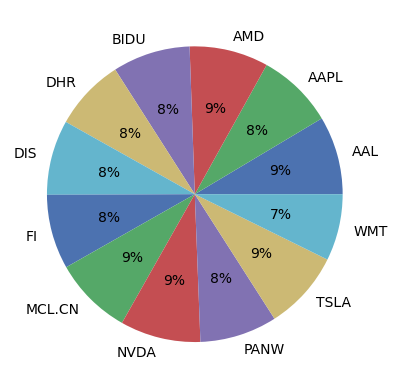

In [12]:

#PyportfolioOpt finding weights for our optimized portfolio on the efficient frontier
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() #for maximizing the Sharpe ratio #Optimization
cleaned_weights = ef.clean_weights() #to clean the raw weights
# Get the Keys and store them in a list
labels = list(cleaned_weights.keys())
# Get the Values and store them in a list
values = list(cleaned_weights.values())
fig, ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.0f%%')
print('Portfolio Allocation')
plt.show(fig)

In [13]:
#Displaying cleaned weights dictionary output
cleaned_weights

OrderedDict([('AAL', 0.08565),
             ('AAPL', 0.08359),
             ('AMD', 0.08639),
             ('BIDU', 0.08486),
             ('DHR', 0.07821),
             ('DIS', 0.08194),
             ('FI', 0.08156),
             ('MCL.CN', 0.08585),
             ('NVDA', 0.08802),
             ('PANW', 0.08452),
             ('TSLA', 0.08651),
             ('WMT', 0.07289)])

In [14]:
#Taking the cleaned weights and inserting them into a df.  
#Named columns and set the index as the Stock column to easily work with additional downstream data.
clean_weights_df = pd.DataFrame(list(cleaned_weights.items()), columns=['Stock', 'Weight'])
clean_weights_df.set_index("Stock", inplace=True)
clean_weights_df

,Weight
Stock,
AAL,0.086
AAPL,0.084
AMD,0.086
BIDU,0.085
DHR,0.078
DIS,0.082
FI,0.082
MCL.CN,0.086
NVDA,0.088


In [15]:
#Finding the discrete allocation using pyportfolioOpt with prices on a given date, our weights, and portfolio size
latest_prices = prices.loc[portfolio_creation_date]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio(verbose=False)
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $132.69 leftover


{'AAL': 726,
 'AAPL': 45,
 'AMD': 73,
 'BIDU': 80,
 'DHR': 40,
 'DIS': 93,
 'FI': 67,
 'MCL.CN': 114473,
 'NVDA': 18,
 'PANW': 33,
 'TSLA': 40,
 'WMT': 44}

In [16]:
ef.portfolio_performance(verbose=True);

Expected annual return: 41.1%
Annual volatility: 27.3%
Sharpe Ratio: 1.43


In [17]:
idx = pd.date_range( start='2013-01-01',end='2023-11-09', freq='M')

stock_data_pctchange = prices.pct_change().cumsum()

stock_data_pctchange.dropna(how="all")

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
Date,,,,,,,,,,,,
2013-11-12,0.011,0.002,0.030,-0.008,-0.006,-0.008,0.002,0.000,0.002,-0.014,-0.048,-0.004
2013-11-13,0.002,0.003,0.059,0.009,-0.008,0.009,0.017,0.000,0.029,-0.010,-0.041,-0.001
2013-11-14,0.017,0.018,0.053,0.049,0.001,0.025,0.017,0.000,0.034,0.008,-0.049,0.001
2013-11-15,0.027,0.012,0.048,0.070,0.002,0.024,0.030,0.000,0.031,0.091,-0.065,0.003
2013-11-18,0.048,-0.001,0.039,0.073,0.003,0.017,0.038,0.000,0.006,0.064,-0.167,0.003
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,0.614,2.804,5.153,0.638,1.683,0.667,1.827,16.760,5.886,3.586,4.686,1.162
2023-11-07,0.622,2.818,5.169,0.635,1.697,0.674,1.824,16.760,5.891,3.608,4.699,1.167
2023-11-08,0.644,2.824,5.170,0.629,1.689,0.673,1.831,16.760,5.904,3.604,4.699,1.159


In [18]:
stock_data_pctchange.hvplot.line(
    xlabel="Year", 
    ylabel="Daily Return",
    title="Value"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [19]:
#Taking the allocation dictionary above and inserting it into  df.
alloc_df = pd.DataFrame(list(alloc.items()), columns=['Stock', 'Value'])
alloc_df.set_index("Stock", inplace=True)
alloc_df

,Value
Stock,
AAL,726
AAPL,45
AMD,73
BIDU,80
DHR,40
DIS,93
FI,67
MCL.CN,114473
NVDA,18


In [20]:
#Checking current values per given stock
current_values = prices.loc[portfolio_rebalance_date] * alloc_df["Value"]
current_values

AAL      8566.800
AAPL     8388.000
AMD      8657.070
BIDU     8475.200
DHR      7880.000
DIS      8209.110
FI       8141.170
MCL.CN   8585.475
NVDA     8700.300
PANW     8365.830
TSLA     8586.000
WMT      7312.360
dtype: float64

In [21]:
#Taking the sum
current_values_sum = current_values.sum(numeric_only=True)
current_values_sum

99867.31475575268

In [22]:
#Adding cash leftover
total_value = current_values_sum + leftover
total_value

99999.99988852299

In [23]:
#Getting the daily returns per stock
combined_returns_ef = prices.pct_change()
combined_returns_ef

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
Date,,,,,,,,,,,,
2013-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-12,0.011,0.002,0.030,-0.008,-0.006,-0.008,0.002,0.000,0.002,-0.014,-0.048,-0.004
2013-11-13,-0.009,0.001,0.029,0.017,-0.002,0.018,0.015,0.000,0.027,0.004,0.007,0.002
2013-11-14,0.015,0.014,-0.006,0.039,0.009,0.015,0.000,0.000,0.004,0.018,-0.008,0.002
2013-11-15,0.010,-0.006,-0.006,0.021,0.001,-0.000,0.013,0.000,-0.003,0.083,-0.016,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,-0.027,0.015,-0.004,-0.011,-0.012,-0.012,0.001,0.000,0.017,-0.027,-0.003,0.001
2023-11-07,0.008,0.014,0.015,-0.004,0.014,0.007,-0.004,0.000,0.004,0.021,0.013,0.005
2023-11-08,0.022,0.006,0.001,-0.005,-0.007,-0.001,0.008,0.000,0.013,-0.004,-0.000,-0.008


In [24]:
#Finding the returns of the optimized portfolio
portfolio_returns_ef = combined_returns_ef.dot(clean_weights_df["Weight"])
portfolio_returns_ef

Date
2013-11-11      NaN
2013-11-12   -0.003
2013-11-13    0.009
2013-11-14    0.009
2013-11-15    0.008
              ...  
2023-11-06   -0.005
2023-11-07    0.008
2023-11-08    0.002
2023-11-09   -0.003
2023-11-10    0.016
Length: 2562, dtype: float64

In [25]:
#Finding the cumulative returns of the optimized portfolio
cumulative_returns_ef = (1 + portfolio_returns_ef).cumprod()
cumulative_returns_ef

Date
2013-11-11      NaN
2013-11-12    0.997
2013-11-13    1.006
2013-11-14    1.015
2013-11-15    1.023
              ...  
2023-11-06   32.761
2023-11-07   33.020
2023-11-08   33.094
2023-11-09   32.996
2023-11-10   33.534
Length: 2562, dtype: float64

In [26]:
#Simulating growth of our 100k initial investment
investment_ammount = 100000
cumulative_profit_ef = investment_ammount * cumulative_returns_ef
cumulative_profit_ef.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profit of Optimized Portfolio",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

:Curve   [Date]   (0)

In [27]:
#Dictionary of equal weights
equal_weights = {'AAL': 0.08333,
             'BIDU': 0.08333,
             'DHR': 0.08333,
             'DIS': 0.08333,
             'FI': 0.08333,
             'AAPL': 0.08333,
             'MCL.CN': 0.08333,
             'NVDA': 0.08333,
             'PANW': 0.08333,
             'AMD': 0.08333,
             'TSLA': 0.08333,
             'WMT': 0.08333}

print(equal_weights)

{'AAL': 0.08333, 'BIDU': 0.08333, 'DHR': 0.08333, 'DIS': 0.08333, 'FI': 0.08333, 'AAPL': 0.08333, 'MCL.CN': 0.08333, 'NVDA': 0.08333, 'PANW': 0.08333, 'AMD': 0.08333, 'TSLA': 0.08333, 'WMT': 0.08333}


In [28]:
#Inserting equal weights into a df
equal_weights_df = pd.DataFrame(list(equal_weights.items()), columns=['Stock', 'Weight'])
equal_weights_df.set_index("Stock", inplace=True)
equal_weights_df

,Weight
Stock,
AAL,0.083
BIDU,0.083
DHR,0.083
DIS,0.083
FI,0.083
AAPL,0.083
MCL.CN,0.083
NVDA,0.083
PANW,0.083


In [29]:
#Using PyportfolioOpt again to find allocations for this equal weight portfolio
latest_prices = prices.loc[portfolio_creation_date]  # prices as of the day you are allocating
da_ew = DiscreteAllocation(equal_weights, latest_prices, total_portfolio_value=100000)
alloc_ew, leftover_ew = da_ew.lp_portfolio(verbose=False)
print(f"Discrete allocation performed with ${leftover_ew:.2f} leftover")
alloc_ew

Discrete allocation performed with $56.24 leftover


{'AAL': 706,
 'BIDU': 45,
 'DHR': 70,
 'DIS': 79,
 'FI': 42,
 'AAPL': 94,
 'MCL.CN': 69,
 'NVDA': 111136,
 'PANW': 17,
 'AMD': 33,
 'TSLA': 39,
 'WMT': 50}

In [30]:
#Inserting allocations into a df
alloc_ew_df = pd.DataFrame(list(alloc_ew.items()), columns=['Stock', 'Value'])
alloc_ew_df.set_index("Stock", inplace=True)
alloc_ew_df

,Value
Stock,
AAL,706
BIDU,45
DHR,70
DIS,79
FI,42
AAPL,94
MCL.CN,69
NVDA,111136
PANW,17


In [31]:
#Finding the current values per stock
current_values_ew = prices.loc[portfolio_rebalance_date] * alloc_ew_df["Value"]
current_values_ew

AAL          8330.800
AAPL        17521.599
AMD          3913.470
BIDU         4767.300
DHR         13790.000
DIS          6973.330
FI           5103.420
MCL.CN          5.175
NVDA     53717586.278
PANW         4309.670
TSLA         8371.350
WMT          8309.500
dtype: float64

In [32]:
#Finding the current value of the portfolio
current_values_ew_sum = current_values_ew.sum(numeric_only=True)
current_values_ew_sum

53798981.89248563

In [33]:
#adding the leftover cash back to get the total value
total_value_ew = current_values_ew_sum + leftover_ew
total_value_ew

53799038.13271482

In [34]:
#Getting returns for our equal weight portfolio
combined_returns_ew = prices.pct_change()
combined_returns_ew

,AAL,AAPL,AMD,BIDU,DHR,DIS,FI,MCL.CN,NVDA,PANW,TSLA,WMT
Date,,,,,,,,,,,,
2013-11-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-11-12,0.011,0.002,0.030,-0.008,-0.006,-0.008,0.002,0.000,0.002,-0.014,-0.048,-0.004
2013-11-13,-0.009,0.001,0.029,0.017,-0.002,0.018,0.015,0.000,0.027,0.004,0.007,0.002
2013-11-14,0.015,0.014,-0.006,0.039,0.009,0.015,0.000,0.000,0.004,0.018,-0.008,0.002
2013-11-15,0.010,-0.006,-0.006,0.021,0.001,-0.000,0.013,0.000,-0.003,0.083,-0.016,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,-0.027,0.015,-0.004,-0.011,-0.012,-0.012,0.001,0.000,0.017,-0.027,-0.003,0.001
2023-11-07,0.008,0.014,0.015,-0.004,0.014,0.007,-0.004,0.000,0.004,0.021,0.013,0.005
2023-11-08,0.022,0.006,0.001,-0.005,-0.007,-0.001,0.008,0.000,0.013,-0.004,-0.000,-0.008


In [35]:
#test_weights = [0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833]
portfolio_returns_ew = combined_returns_ew.dot(equal_weights_df)

In [36]:
#Getting cumulative returns for our equal weight portfolio
cumulative_returns_ew = (1 + portfolio_returns_ew).cumprod()
cumulative_returns_ew

,Weight
Date,
2013-11-11,NaN
2013-11-12,0.997
2013-11-13,1.006
2013-11-14,1.014
2013-11-15,1.023
...,...
2023-11-06,30.608
2023-11-07,30.849
2023-11-08,30.911


In [37]:
#investment_ammount = 100000
cumulative_profit_ew = investment_ammount * cumulative_returns_ew
cumulative_profit_ew.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profit of Equal Weight Portfolio",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

:Curve   [Date]   (Weight)

In [38]:
#Getting 10y data for SPY, our baseline
spy = ["SPY"] 
spy_data = yf.download(spy, period="10y")

[*********************100%%**********************]  1 of 1 completed


In [39]:
#Closing prices for SPY
spy_prices = pd.DataFrame(spy_data["Adj Close"].dropna(how="all"))
spy_prices.tail()

,Adj Close
Date,
2023-11-06,435.690
2023-11-07,436.930
2023-11-08,437.250
2023-11-09,433.840
2023-11-10,440.610


In [40]:
# Calculate Daily Returns
daily_returns_spy = spy_prices.pct_change()
daily_returns_spy.columns = ["SPY"]
daily_returns_spy.head()

,SPY
Date,
2013-11-11,NaN
2013-11-12,-0.002
2013-11-13,0.008
2013-11-14,0.005
2013-11-15,0.004


In [41]:
#SPY cumulative returns
cumulative_returns_spy = (1 + daily_returns_spy).cumprod()
cumulative_returns_spy.head()

,SPY
Date,
2013-11-11,NaN
2013-11-12,0.998
2013-11-13,1.006
2013-11-14,1.011
2013-11-15,1.015


In [42]:
#Getting std dev for spy
stddev_spy = daily_returns_spy.std()
stddev_spy

SPY   0.011
dtype: float64

In [43]:
#spy std dev annualized
stddev_annualized_spy = stddev_spy * np.sqrt(252)
stddev_annualized_spy

SPY   0.175
dtype: float64

In [44]:
#Calculating SPY Sharpe Ratio
sharpe_ratio_spy = (daily_returns_spy.mean() * 252) / (stddev_annualized_spy)
sharpe_ratio_spy

SPY   0.712
dtype: float64

In [45]:
#SPY expected returns
mu_spy = expected_returns.capm_return(spy_prices)
mu_spy

Adj Close   0.116
Name: mkt, dtype: float64

In [46]:
cumulative_profit_spy = investment_ammount * cumulative_returns_spy
cumulative_profit_spy.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profit of the SP500 using SPY",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

:Curve   [Date]   (SPY)

In [47]:
#Combining the 3 portfolios to 1 df to better display results
combined_df = pd.concat([cumulative_profit_ef,cumulative_profit_ew,cumulative_profit_spy], axis='columns', join='inner')
combined_df.columns = ["Optimized", "Equal Weight","SPY"]
combined_df

,Optimized,Equal Weight,SPY
Date,,,
2013-11-11,NaN,NaN,NaN
2013-11-12,99660.795,99658.347,99796.970
2013-11-13,100586.520,100565.892,100597.816
2013-11-14,101462.407,101441.026,101099.708
2013-11-15,102300.554,102276.380,101539.591
...,...,...,...
2023-11-06,3276053.244,3060756.186,294797.639
2023-11-07,3302017.070,3084927.948,295636.644
2023-11-08,3309359.174,3091122.942,295853.168


In [48]:
combined_df.hvplot(
    x='Date', 
    #y='housing_units',
    title="Cumulative Profits Compared",
    rot=45,
    xlabel='Date', 
    ylabel='Profit'
).opts(yformatter='%.0f')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)